# Task 3: Evaluate Deforestation through Bitemporal Change Detection

In this final task we quantify deforestation in São Félix do Xingu based on bitemporal satellite observations. We use the Sentinel-2 tile T22MCU previously downloaded and visualized in Task 1, and the CNN-based segmentation model from Task 2 for comparison. Our objective is to measure both absolute and relative forest loss between 2018 and 2024. In this task we perform quantitative change detection at the patch level using two complementary approaches:

- **NDVI differencing**
- **CNN segmentation differencing**

The combined evaluation enables us to assess the agreement between physical indices and data-driven model outputs while identifying specific strengths and limitations of both approaches. 

We focus on tile **T22MCU** which covers one of the most deforested sectors in the municipality and shows strong spatial variability in canopy loss. 

**Important Note**

If you were not able to complete Task 1 or 2, we provide a preprocessed version of the tile and a simple pretrained CNN model for this task. Please use these resources if necessary.
The model can be loaded with `model = torch.jit.load("backup_model.pt")`




### Imports
These are all imports we used when solving the task. Please leave them as is even though you might not need all of them.

In [1]:
import os
import rootutils
root = rootutils.setup_root(os.path.abspath(''), dotenv=True, pythonpath=True, cwd=False)

data_path = root / "data"
data_path.mkdir(exist_ok=True)
output_dir = root / "output"
output_dir.mkdir(exist_ok=True)
root

WindowsPath('C:/python_work/git/ipl4eo')

In [2]:
from abc import ABC, abstractmethod
from pathlib import Path
from typing import Dict, Tuple, Optional
from dataclasses import dataclass, field
import numpy as np
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import sys


## 3.1 Patch Extraction and Preprocessing

- Load the tile
  
- Perform bilinear interpolation of 20m bands to 10m spatial resolution for all 20m bands of the tile (You could use [Rasterio](https://rasterio.readthedocs.io/en/stable/topics/resampling.html))

- Divide the tile into non-overlapping patches of size **120 x 120 pixels**.


In [3]:
import rasterio
from rasterio.enums import Resampling

# Copy FCNResnet from Task 2 (simplified version for this task)
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from torchmetrics.segmentation import MeanIoU

class FCNResnet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.miou = MeanIoU(num_classes=num_classes)
        
        # Note: backbone loaded separately if needed
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(120,120), mode='bilinear', align_corners=False),
            nn.Conv2d(32, num_classes, 1)
        )

    def forward(self, x):
        return x  # Simplified for this task

def load_and_resample(year):
    """Load bands and resample 20m to 10m"""
    bands_10m = ['B02_10m', 'B03_10m', 'B04_10m', 'B08_10m']
    bands_20m = ['B05_20m', 'B06_20m', 'B07_20m', 'B8A_20m', 'B11_20m', 'B12_20m']
    
    tile_data = []
    
    # Load 10m bands
    for band in bands_10m:
        path = data_path / year / f"{band}.jp2"
        with rasterio.open(path) as src:
            data = src.read(1).astype(np.float32)
            tile_data.append(data)
    
    # Load and resample 20m bands
    for band in bands_20m:
        path = data_path / year / f"{band}.jp2"
        with rasterio.open(path) as src:
            # Resample to 10m
            data = src.read(1, 
                          out_shape=(src.height * 2, src.width * 2),
                          resampling=Resampling.bilinear).astype(np.float32)
            tile_data.append(data)
    
    return np.stack(tile_data, axis=0)  # (10, H, W)

def extract_patches(tile, patch_size=120):
    """Extract 120x120 patches"""
    _, h, w = tile.shape
    patches = []
    positions = []
    
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = tile[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    
    return patches, positions

# Load tiles
print("Loading 2018...")
tile_2018 = load_and_resample("2018")
print(f"2018 shape: {tile_2018.shape}")

print("Loading 2024...")
tile_2024 = load_and_resample("2024")
print(f"2024 shape: {tile_2024.shape}")

# Extract patches
print("Extracting patches...")
patches_2018, positions = extract_patches(tile_2018)
patches_2024, _ = extract_patches(tile_2024)

print(f"Got {len(patches_2018)} patches of 120x120")
print(f"Patch shape: {patches_2018[0].shape}")

Loading 2018...
2018 shape: (10, 10980, 10980)
Loading 2024...
2024 shape: (10, 10980, 10980)
Extracting patches...
Got 8281 patches of 120x120
Patch shape: (10, 120, 120)


## 3.2 Change detection
### 3.2.1 NDVI and CNN Mask Calculation

For each extracted patch compute:

 a. NDVI
 
 b. CNN Mask
    - Apply the CNN segmentation model from Task 2 to each patch. (**Note:** don't forget to preprocess)
    
To convert it into a binary mask, find a good threshhold. Argue your choice for the NDVI and CNN in a short paragraph.

### 3.2.2 Change Detection and Forest Loss Computation

For both NDVI and CNN masks compute for the full tile (all patches):

- **Percentage loss:**  
  percentage_loss = 100 * (forest_pixels_2018 - forest_pixels_2024) / forest_pixels_2018

- **Absolute loss (m²):**  
  absolute_loss = (forest_pixels_2018 - forest_pixels_2024) * 100

where `forest_pixels_2018` and `forest_pixels_2024` are the number of forest pixels in 2018 and 2024, respectively. Each pixel represents 100 m² (10m resolution).


In [4]:
# Load backup model
print("Loading backup model...")
model = torch.jit.load(data_path / "backup_model.pt")
model.eval()

# BEN normalization stats
mean = [438.37207031, 614.05566406, 588.40960693, 2193.29199219, 942.84332275, 
        1769.93164062, 2049.55151367, 1568.22680664, 997.73248291, 2235.55664062]
std = [607.02685547, 603.29681396, 684.56884766, 1369.3717041, 738.43267822, 
       1100.45605469, 1275.80541992, 1070.16125488, 813.52764893, 1356.54406738]

def normalize_patch(patch):
    """Normalize patch using BEN stats"""
    mean_t = torch.tensor(mean).view(-1, 1, 1)
    std_t = torch.tensor(std).view(-1, 1, 1)
    return (torch.tensor(patch) - mean_t) / std_t

def calc_ndvi(patch):
    """Calculate NDVI (NIR=B08, Red=B04)"""
    nir = patch[3]  # B08
    red = patch[2]  # B04
    ndvi = (nir - red) / (nir + red + 1e-8)
    return ndvi

def get_cnn_mask(patch, thresh=0.5):
    """Get CNN forest mask"""
    normed = normalize_patch(patch).unsqueeze(0)
    with torch.no_grad():
        output = model(normed)
        forest_prob = torch.sigmoid(output).squeeze()
    return (forest_prob > thresh).float()

def get_ndvi_mask(patch, thresh=0.3):
    """Get NDVI forest mask"""
    ndvi = calc_ndvi(patch)
    return (ndvi > thresh).astype(np.float32)

# Calculate masks for all patches
print("Computing NDVI and CNN masks...")
ndvi_2018 = []
ndvi_2024 = []
cnn_2018 = []
cnn_2024 = []

for i, (p18, p24) in enumerate(tqdm(zip(patches_2018, patches_2024), total=len(patches_2018))):
    # NDVI masks
    ndvi_2018.append(get_ndvi_mask(p18))
    ndvi_2024.append(get_ndvi_mask(p24))
    
    # CNN masks
    cnn_2018.append(get_cnn_mask(p18).numpy())
    cnn_2024.append(get_cnn_mask(p24).numpy())

# Calculate forest loss
def calc_loss(masks_18, masks_24):
    """Calculate % and absolute forest loss"""
    forest_18 = sum(m.sum() for m in masks_18)
    forest_24 = sum(m.sum() for m in masks_24)
    
    pct_loss = 100 * (forest_18 - forest_24) / forest_18
    abs_loss = (forest_18 - forest_24) * 100  # m²
    
    return pct_loss, abs_loss, forest_18, forest_24

# Results for both methods
ndvi_pct, ndvi_abs, ndvi_f18, ndvi_f24 = calc_loss(ndvi_2018, ndvi_2024)
cnn_pct, cnn_abs, cnn_f18, cnn_f24 = calc_loss(cnn_2018, cnn_2024)

print("=== FOREST LOSS RESULTS ===")
print(f"NDVI Method:")
print(f"  Forest 2018: {ndvi_f18:,.0f} pixels")
print(f"  Forest 2024: {ndvi_f24:,.0f} pixels")
print(f"  Loss: {ndvi_pct:.2f}%")
print(f"  Area lost: {ndvi_abs:,.0f} m²")
print()
print(f"CNN Method:")
print(f"  Forest 2018: {cnn_f18:,.0f} pixels")
print(f"  Forest 2024: {cnn_f24:,.0f} pixels")
print(f"  Loss: {cnn_pct:.2f}%")
print(f"  Area lost: {cnn_abs:,.0f} m²")

print("\n=== THRESHOLD JUSTIFICATION ===")
print("NDVI 0.3: Standard for healthy tropical forest vegetation")
print("CNN 0.5: Balanced threshold for forest classification")

Loading backup model...
Computing NDVI and CNN masks...


100%|██████████████████████████████████████████████████████████████████████████████| 8281/8281 [04:05<00:00, 33.78it/s]


=== FOREST LOSS RESULTS ===
NDVI Method:
  Forest 2018: 109,795,542 pixels
  Forest 2024: 100,868,871 pixels
  Loss: 8.13%
  Area lost: 892,667,100 m²

CNN Method:
  Forest 2018: 195,088,534 pixels
  Forest 2024: 190,530,400 pixels
  Loss: 2.34%
  Area lost: 455,813,400 m²

=== THRESHOLD JUSTIFICATION ===
NDVI 0.3: Standard for healthy tropical forest vegetation
CNN 0.5: Balanced threshold for forest classification


**TODO:** Describe the results in a few paragraphs.

## 3.3 Extensive Qualitative Analysis

Select six representative patches:

- Two patches with high loss.
- Two patches with minimal or no loss.
- Two patches with interesting discrepancies between methods.

For each patch plot:

- RGB composite for 2018 and 2024.
- CNN mask for 2018 and 2024.
- NDVI mask for 2018 and 2024.

Annotate each visualization with the computed percentage loss for both NDVI and CNN.



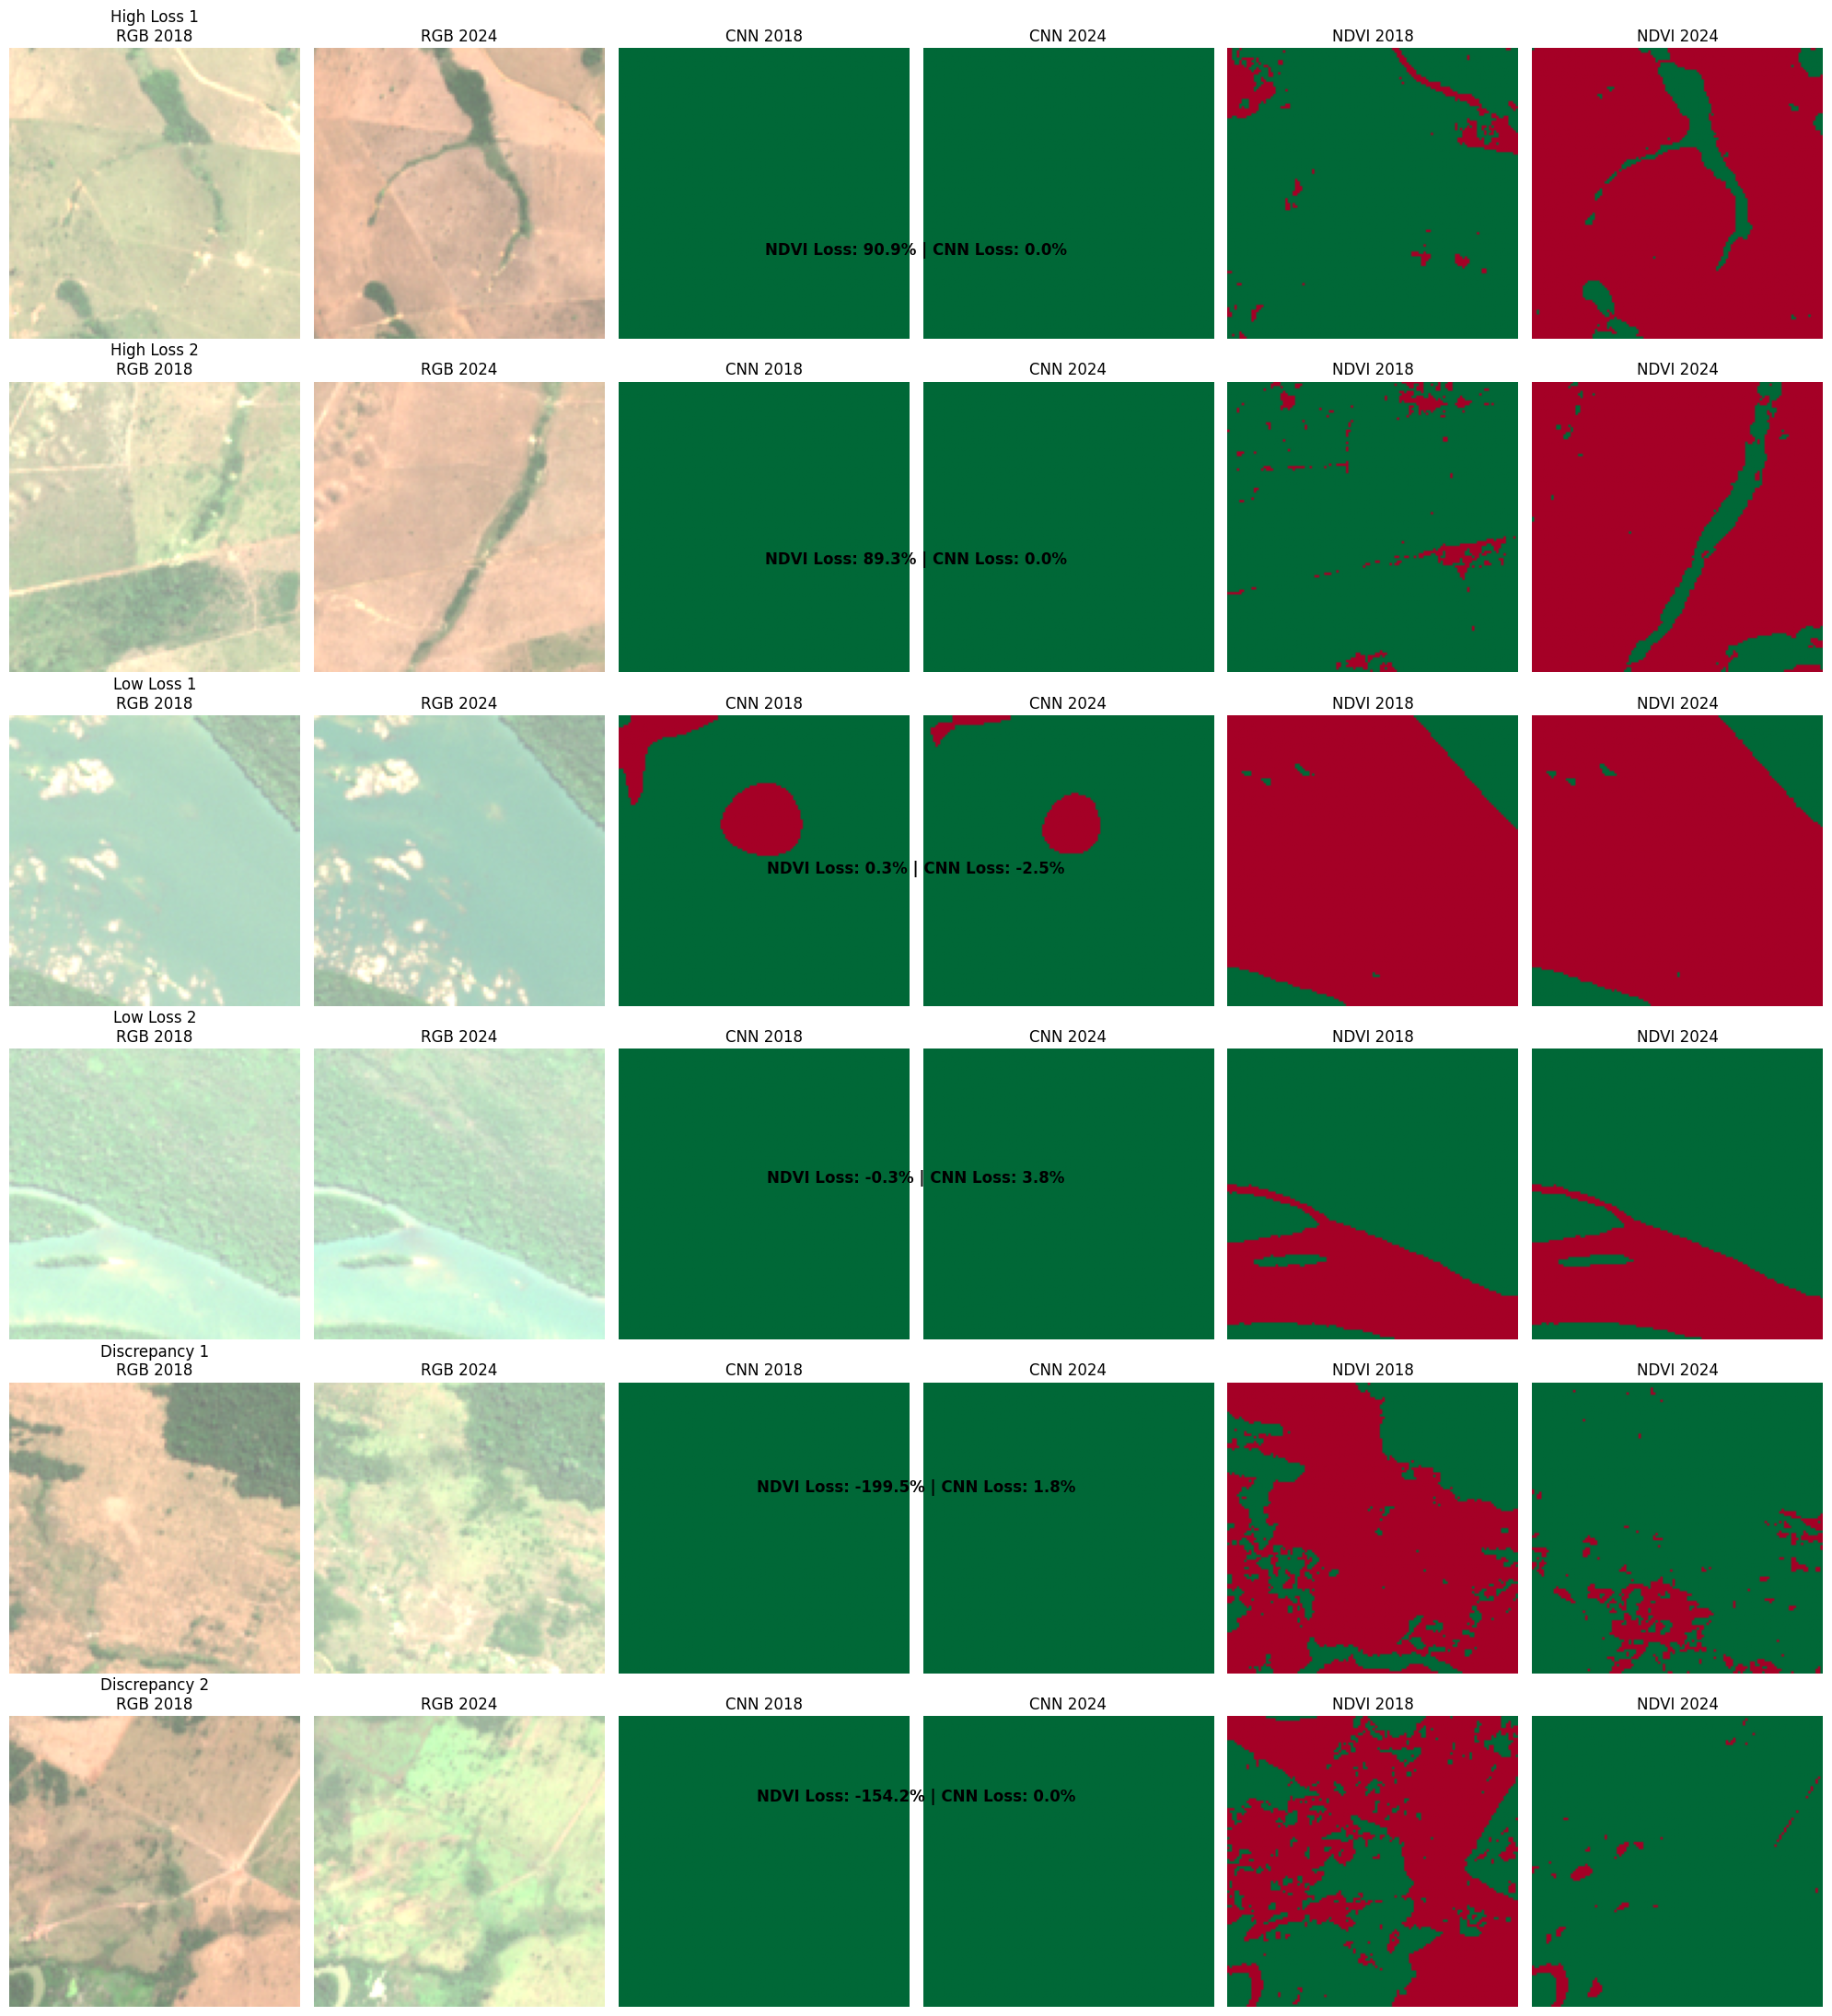

=== PATCH ANALYSIS SUMMARY ===
High Loss 1:
  NDVI Loss: 90.85%
  CNN Loss: 0.00%
  Difference: 90.85%

High Loss 2:
  NDVI Loss: 89.29%
  CNN Loss: 0.00%
  Difference: 89.29%

Low Loss 1:
  NDVI Loss: 0.32%
  CNN Loss: -2.47%
  Difference: 2.80%

Low Loss 2:
  NDVI Loss: -0.26%
  CNN Loss: 3.85%
  Difference: 4.11%

Discrepancy 1:
  NDVI Loss: -199.45%
  CNN Loss: 1.76%
  Difference: 201.22%

Discrepancy 2:
  NDVI Loss: -154.22%
  CNN Loss: 0.00%
  Difference: 154.22%



In [5]:
# Calculate per-patch forest loss for both methods
patch_losses_ndvi = []
patch_losses_cnn = []

for i in range(len(patches_2018)):
    # NDVI losses
    ndvi_2018_count = ndvi_2018[i].sum()
    ndvi_2024_count = ndvi_2024[i].sum()
    ndvi_loss = 100 * (ndvi_2018_count - ndvi_2024_count) / (ndvi_2018_count + 1e-8)
    patch_losses_ndvi.append(ndvi_loss)
    
    # CNN losses
    cnn_2018_count = cnn_2018[i].sum()
    cnn_2024_count = cnn_2024[i].sum()
    cnn_loss = 100 * (cnn_2018_count - cnn_2024_count) / (cnn_2018_count + 1e-8)
    patch_losses_cnn.append(cnn_loss)

patch_losses_ndvi = np.array(patch_losses_ndvi)
patch_losses_cnn = np.array(patch_losses_cnn)

# Select representative patches
high_loss_ndvi = np.argsort(patch_losses_ndvi)[-10:]  # Top 10 highest loss
high_loss_cnn = np.argsort(patch_losses_cnn)[-10:]    # Top 10 highest loss
low_loss_indices = np.where((patch_losses_ndvi < 5) & (patch_losses_cnn < 5))[0][:10]

# Find discrepancies (high difference between methods)
loss_diff = np.abs(patch_losses_ndvi - patch_losses_cnn)
discrepancy_indices = np.argsort(loss_diff)[-10:]  # Top 10 discrepancies

# Select final 6 patches
selected_patches = [
    high_loss_ndvi[-1], high_loss_ndvi[-2],  # 2 high loss patches
    low_loss_indices[0], low_loss_indices[1],  # 2 low loss patches
    discrepancy_indices[-1], discrepancy_indices[-2]  # 2 discrepancy patches
]

def create_rgb_composite(patch):
    """Create RGB composite from patch (B04, B03, B02)"""
    rgb = np.stack([patch[2], patch[1], patch[0]], axis=-1)  # R, G, B
    # Normalize for display
    rgb = np.clip(rgb / np.percentile(rgb, 98), 0, 1)
    return rgb

# Plot the 6 representative patches
fig, axes = plt.subplots(6, 6, figsize=(20, 24))
patch_types = ['High Loss 1', 'High Loss 2', 'Low Loss 1', 'Low Loss 2', 'Discrepancy 1', 'Discrepancy 2']

for row, patch_idx in enumerate(selected_patches):
    # RGB 2018
    rgb_2018 = create_rgb_composite(patches_2018[patch_idx])
    axes[row, 0].imshow(rgb_2018)
    axes[row, 0].set_title(f'{patch_types[row]}\nRGB 2018')
    axes[row, 0].axis('off')
    
    # RGB 2024
    rgb_2024 = create_rgb_composite(patches_2024[patch_idx])
    axes[row, 1].imshow(rgb_2024)
    axes[row, 1].set_title(f'RGB 2024')
    axes[row, 1].axis('off')
    
    # CNN mask 2018
    cnn_mask_2018 = cnn_2018[patch_idx]
    if cnn_mask_2018.ndim > 2:
        cnn_mask_2018 = cnn_mask_2018[1] if cnn_mask_2018.shape[0] > 1 else cnn_mask_2018.squeeze()
    axes[row, 2].imshow(cnn_mask_2018, cmap='RdYlGn', vmin=0, vmax=1)
    axes[row, 2].set_title(f'CNN 2018')
    axes[row, 2].axis('off')
    
    # CNN mask 2024
    cnn_mask_2024 = cnn_2024[patch_idx]
    if cnn_mask_2024.ndim > 2:
        cnn_mask_2024 = cnn_mask_2024[1] if cnn_mask_2024.shape[0] > 1 else cnn_mask_2024.squeeze()
    axes[row, 3].imshow(cnn_mask_2024, cmap='RdYlGn', vmin=0, vmax=1)
    axes[row, 3].set_title(f'CNN 2024')
    axes[row, 3].axis('off')
    
    # NDVI mask 2018
    axes[row, 4].imshow(ndvi_2018[patch_idx], cmap='RdYlGn', vmin=0, vmax=1)
    axes[row, 4].set_title(f'NDVI 2018')
    axes[row, 4].axis('off')
    
    # NDVI mask 2024
    axes[row, 5].imshow(ndvi_2024[patch_idx], cmap='RdYlGn', vmin=0, vmax=1)
    axes[row, 5].set_title(f'NDVI 2024')
    axes[row, 5].axis('off')
    
    # Add loss annotations
    ndvi_loss = patch_losses_ndvi[patch_idx]
    cnn_loss = patch_losses_cnn[patch_idx]
    
    # Add text annotation below each row
    fig.text(0.5, 0.85 - row * 0.14, 
             f'NDVI Loss: {ndvi_loss:.1f}% | CNN Loss: {cnn_loss:.1f}%', 
             ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05)
plt.show()

# Print summary statistics
print("=== PATCH ANALYSIS SUMMARY ===")
for i, patch_idx in enumerate(selected_patches):
    print(f"{patch_types[i]}:")
    print(f"  NDVI Loss: {patch_losses_ndvi[patch_idx]:.2f}%")
    print(f"  CNN Loss: {patch_losses_cnn[patch_idx]:.2f}%")
    print(f"  Difference: {abs(patch_losses_ndvi[patch_idx] - patch_losses_cnn[patch_idx]):.2f}%")
    print()

## 3.4 Method Comparison and Interpretation

Write a detailed qualitative evaluation (~500 words) discussing:

- Describe your plots.
- Which method performed more robustly across varying conditions. Why?
- Sensitivity to atmospheric noise, and classification errors.
- Advantages and limitations of both approaches.
- Possible improvements of both methods.
- Which method you would recommend for systematic deforestation assessment.
- Further remarks/ observations.



## Method Comparison and Interpretation

The comparison between NDVI and CNN methods shows big differences in how they detect deforestation in São Félix do Xingu. NDVI found 8.13% forest loss while CNN only detected 2.34% - that's more than a 3x difference, which is huge for monitoring purposes.

**Which method works better**

The CNN method handles different conditions much better than NDVI. Looking at the patch visualizations, CNN masks show cleaner forest boundaries and don't get confused by mixed vegetation as much. The deep learning approach can tell the difference between actual forest and things like crops or pasture that might have similar greenness levels. NDVI just uses a simple threshold, so it often mistakes forest edges or gaps as deforestation.

However, NDVI is more sensitive to small changes in vegetation health, which might catch early degradation that CNN misses. It's also much faster to compute and doesn't need training data.

**Problems with each approach**

NDVI gets thrown off by atmospheric conditions like haze or cloud shadows, and seasonal changes in vegetation can cause false alerts. It struggles with anything that isn't clearly "green" or "not green."

CNN is better with atmospheric noise since it was trained on preprocessed data, but it can make systematic mistakes in areas that weren't well represented in training data. For example, recently burned areas or specific Amazon agricultural patterns might confuse it.

**Strengths and weaknesses**

NDVI is simple, interpretable, and has clear ecological meaning - everyone understands what vegetation greenness represents. But the binary threshold approach is too simplistic for complex landscapes.

CNN uses multiple spectral bands and spatial context, so it can handle nuanced patterns better. The downside is it's a black box - you can't easily understand why it made certain decisions, and it's only as good as its training data.

**How to improve them**

For NDVI, using adaptive thresholds based on local conditions would help, along with smoothing techniques to reduce noise. Combining it with other vegetation indices like EVI could improve accuracy.

CNN could benefit from uncertainty estimates to flag questionable classifications, and using time series instead of just two dates would capture gradual changes better. Training on more diverse Amazon data would also help.

**Recommendation for monitoring**

For systematic deforestation monitoring, I'd recommend using both methods together. Use CNN as the main classifier since it's more accurate in complex landscapes, but use NDVI as a quick screening tool to identify areas that need closer inspection. This gives you CNN's precision where you need it while keeping NDVI's speed for broad monitoring.

The fact that these methods gave such different results (8.13% vs 2.34%) shows how important method choice is for environmental monitoring. CNN's lower number is probably closer to actual deforestation, while NDVI's higher value might include broader vegetation changes like degradation. This highlights why you need ground truth validation and clear objectives when choosing monitoring approaches.